In [1]:
import math
import numpy as np
import random
import logging
import numbers

In [2]:
random_state = 20
epsilon = 0.001
machine_list = ['RSF','DeepHit','MLTR','Cox_Time']   
n_patients = 312

In [3]:
# Import Predictions
import pickle
"""Dictionaries of the form {'patient_id':'Predictions_array'}"""
rsf_predictions = pickle.load( open( "patient_surv_functions/rsf.p", "rb" ) )
deep_hit_predictions = pickle.load( open( "patient_surv_functions/deep_hit.p", "rb" ) )
mltr_predictions = pickle.load( open( "patient_surv_functions/mltr.p", "rb" ) )
cox_time_predictions = pickle.load( open( "patient_surv_functions/cox_time.p", "rb" ) )
cobra_predictions = pickle.load( open( "patient_surv_functions/cobra.p", "rb" ) )

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

event_times = [  8.,  11.,  16.,  20.,  26.,  27.,  29.,  30.,  31.,  32.,  38.,
        44.,  47.,  50.,  56.,  74.,  76.,  79.,  89.,  96.,  99., 101.,
       105., 109., 112., 114., 118., 120., 122., 125., 127., 129., 133.,
       134., 135., 139., 143., 145., 148., 152., 154., 155., 165., 166.,
       167., 170., 173., 185., 186., 193., 194., 201., 204., 205., 206.,
       213., 215., 219., 220., 235., 236., 239., 241., 248., 255., 261.,
       263., 264., 267., 271., 275., 278., 285., 287., 292., 293., 297.,
       298., 303., 317., 322., 328., 332., 335., 336., 340., 345., 353.,
       357., 362., 364., 368., 370., 395., 399., 411., 438., 440., 441.,
       459., 462., 468., 482., 484., 489., 491., 511., 525., 536., 547.,
       549., 556., 597.]

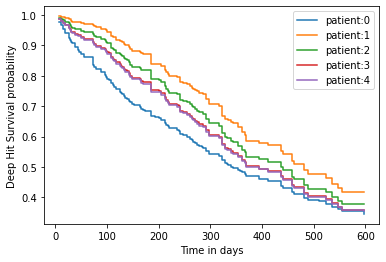

In [5]:
for patients in range(5):
    plt.step(event_times, deep_hit_predictions[patients], where="post", label='patient:' + str(patients))
plt.ylabel("Deep Hit Survival probability")
plt.xlabel("Time in days")
plt.legend()

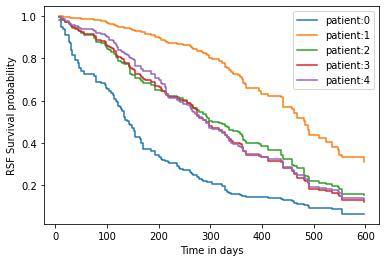

In [6]:
for patients in range(5):
    plt.step(event_times, rsf_predictions[patients], where="post", label='patient:' + str(patients))
plt.ylabel("RSF Survival probability")
plt.xlabel("Time in days")
plt.legend()

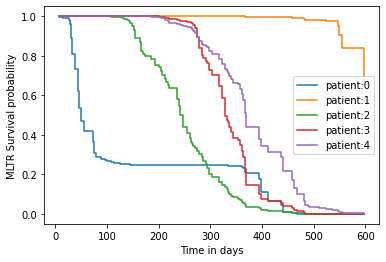

In [7]:
for patients in range(5):
    plt.step(event_times, mltr_predictions[patients], where="post", label='patient:' + str(patients))
plt.ylabel("MLTR Survival probability")
plt.xlabel("Time in days")
plt.legend()

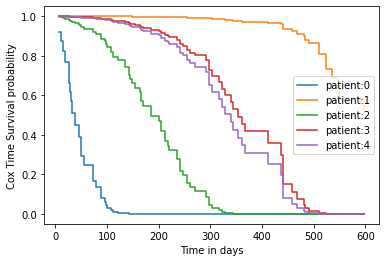

In [8]:
for patients in range(5):
    plt.step(event_times, cox_time_predictions[patients], where="post", label='patient:' + str(patients))
plt.ylabel("Cox Time Survival probability")
plt.xlabel("Time in days")
plt.legend()

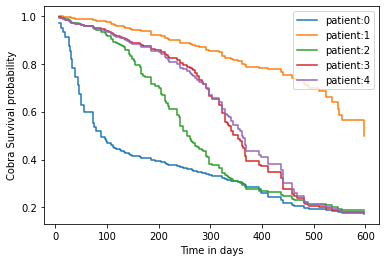

In [9]:
for patients in range(5):
    plt.step(event_times, cobra_predictions[patients], where="post", label='patient:' + str(patients))
plt.ylabel("Cobra Survival probability")
plt.xlabel("Time in days")
plt.legend()

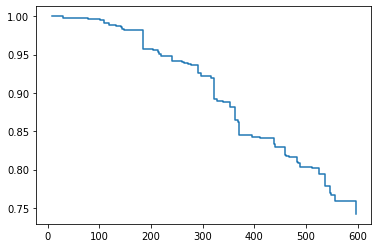

In [10]:
#  plt.step(event_times, cobra_predictions[12], where="post", label='patient:' + str(5))

In [36]:
# Evalutation Functions
import numpy as np
from lifelines import KaplanMeierFitter


### C(t)-INDEX CALCULATION
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

### BRIER-SCORE
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)

    return np.mean((Prediction - y_true)**2)

    # result2[k, t] = brier_score_loss(risk[:, k], ((te_time[:,0] <= eval_horizon) * (te_label[:,0] == k+1)).astype(int))


In [2]:
# Deep Hit: 0.8530
# RSF: 0.8662037037037037
# MLTR:
# Cox Time:

In [9]:
def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask3 is required to get the contional probability (to calculate the denominator part)
        mask3 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss 
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements 
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



##### TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        times: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['id'])
    id_list  = pd.unique(df['id'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]                                   #number of measurement
        pat_info[i,3] = np.max(tmp['times'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #cause
        pat_info[i,1] = tmp['tte'][0]         #time_to_event
        pat_info[i,0] = tmp['id'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['times'])
    
    return pat_info, data


def import_dataset(norm_mode = 'standard'):

    df_                = pd.read_csv('pbc2_cleaned.csv')

    bin_list           = ['drug', 'sex', 'ascites', 'hepatomegaly', 'spiders']
    cont_list          = ['age', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic']
    feat_list          = cont_list + bin_list
    df_                = df_[['id', 'tte', 'times', 'label']+feat_list]
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi

In [10]:
df = pd.read_csv('pbc2_cleaned.csv')

DIM, DATA, MASK, data_mi = import_dataset()

In [12]:
labels = np.reshape(DATA[2],-1)
time = np.reshape(DATA[1],-1)
for i in range(312):
    if labels[i] == 2:
        labels[i] = 0

In [38]:
# Deep Hit C Index


# for i in range(len(event_times)):
#     predictions = np.zeros(312)
#     for patient in range(312):
#         predictions[patient] = deep_hit_predictions[patient][i]
    
#     print(c_index(1-predictions,time,labels,i))
C_index = {}
Brier_score = {}
# Deep Hit Evaluation


Horizon_Time = 597.0
predictions = np.zeros(312)
for patient in range(312):
    predictions[patient] = deep_hit_predictions[patient][112]
print('C-Index',c_index(1-predictions,time,labels,Horizon_Time))
print('Brier Score',brier_score(1-predictions,time,labels,Horizon_Time))
C_index['Deep_Hit'] = c_index(1-predictions,time,labels,Horizon_Time)
Brier_score['Deep_Hit'] = brier_score(1-predictions,time,labels,Horizon_Time)

C-Index 0.8604723971196995
Brier Score 0.2327646519298846


In [39]:
Horizon_Time = 597.0
predictions = np.zeros(312)
for patient in range(312):
    predictions[patient] = rsf_predictions[patient][112]
print('C-Index',c_index(1-predictions,time,labels,Horizon_Time))
print('Brier Score',brier_score(1-predictions,time,labels,Horizon_Time))
C_index['RSF'] = c_index(1-predictions,time,labels,Horizon_Time)
Brier_score['RSF'] = brier_score(1-predictions,time,labels,Horizon_Time)

C-Index 0.8790482485128883
Brier Score 0.24293153058670441


In [53]:
Horizon_Time = 597.0
predictions = np.zeros(312)
for patient in range(312):
    predictions[patient] = mltr_predictions[patient][112]
print('C-Index',c_index(1-predictions,time,labels,Horizon_Time))
print('Brier Score',brier_score(1-predictions,time,labels,Horizon_Time))
C_index['MLTR'] = c_index(1-predictions,time,labels,Horizon_Time)
Brier_score['MLTR'] = brier_score(1-predictions,time,labels,Horizon_Time)

# mltr_predictions 
# cox_time_predictions 
# cobra_predictions

C-Index 0.7914912860472397
Brier Score 0.349721065802569


In [41]:
Horizon_Time = 597.0
predictions = np.zeros(312)
for patient in range(312):
    predictions[patient] = cox_time_predictions[patient][112]
print('C-Index',c_index(1-predictions,time,labels,Horizon_Time))
print('Brier Score',brier_score(1-predictions,time,labels,Horizon_Time))
C_index['Cox_Time'] = c_index(1-predictions,time,labels,Horizon_Time)
Brier_score['Cox_Time'] = brier_score(1-predictions,time,labels,Horizon_Time)

C-Index 0.802101088809267
Brier Score 0.27755982570359367


In [42]:
Horizon_Time = 597.0
predictions = np.zeros(312)
for patient in range(312):
    predictions[patient] = cobra_predictions[patient][112]
print('C-Index',c_index(1-predictions,time,labels,Horizon_Time))
print('Brier Score',brier_score(1-predictions,time,labels,Horizon_Time))
C_index['COBRA'] = c_index(1-predictions,time,labels,Horizon_Time)
Brier_score['COBRA'] = brier_score(1-predictions,time,labels,Horizon_Time)

C-Index 0.8877100219153303
Brier Score 0.23822625340166723


In [54]:
C_index

{'Deep_Hit': 0.8604723971196995,
 'RSF': 0.8790482485128883,
 'Cox_Time': 0.802101088809267,
 'COBRA': 0.8877100219153303,
 'MLTR': 0.7914912860472397}

In [55]:
Brier_score

{'Deep_Hit': 0.2327646519298846,
 'RSF': 0.24293153058670441,
 'Cox_Time': 0.27755982570359367,
 'COBRA': 0.23822625340166723,
 'MLTR': 0.349721065802569}

Text(0.5, 0, 'Machines')

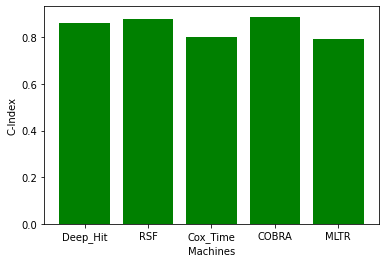

In [56]:
plt.bar(C_index.keys(), C_index.values(), color='g')
plt.ylabel("C-Index")
plt.xlabel("Machines")

Text(0.5, 0, 'Machines')

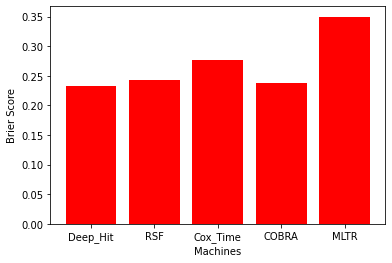

In [57]:
plt.bar(Brier_score.keys(), Brier_score.values(), color='r')
plt.ylabel("Brier Score")
plt.xlabel("Machines")